In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [2]:
train = pd.read_csv('data/train_features.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test_features.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print(train.shape, train_labels.shape)

(1875000, 8) (3125, 3)


In [4]:
x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
# x_train = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
# x_test = x_test[:,:,:,np.newaxis]

100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 1252.99it/s]


In [5]:
x_train.shape

(3125, 6, 600)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, train_labels, test_size=0.2, shuffle = False)

In [7]:
# validation x
x_val= x_val.transpose(0, 2, 1)

In [8]:
# train x
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    return shift_data

In [9]:
shift_data = aug(x_train, 0 , int(random.random()*600))
print(shift_data.shape)

(2500, 6, 600)


In [10]:
x=np.concatenate([x_train, shift_data], axis = 0)

In [11]:
x = x.transpose(0,2,1)
x.shape

(5000, 600, 6)

In [12]:
import tensorflow as tf
import numpy as np

y = tf.keras.utils.to_categorical(y_train['label']) 
y = np.concatenate([y, y], axis = 0)
y.shape

(5000, 61)

In [13]:
y_val = tf.keras.utils.to_categorical(y_val['label']) 
y_val.shape

(625, 61)

In [14]:
x_val.shape
y_val.shape

(625, 61)

In [15]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(64, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32, callbacks = [es],  validation_data = (x_val, y_val))

Epoch 1/100
157/157 [==============================] - 26s 125ms/step - loss: 2.7680 - accuracy: 0.4807 - val_loss: 2.2819 - val_accuracy: 0.5280
Epoch 2/100
157/157 [==============================] - 21s 133ms/step - loss: 2.3750 - accuracy: 0.4959 - val_loss: 2.1152 - val_accuracy: 0.5376
Epoch 3/100
157/157 [==============================] - 22s 142ms/step - loss: 2.0928 - accuracy: 0.5253 - val_loss: 1.9174 - val_accuracy: 0.5504
Epoch 4/100
157/157 [==============================] - 25s 157ms/step - loss: 1.9793 - accuracy: 0.5355 - val_loss: 1.9091 - val_accuracy: 0.5520
Epoch 5/100
157/157 [==============================] - 27s 171ms/step - loss: 1.7808 - accuracy: 0.5718 - val_loss: 1.6725 - val_accuracy: 0.6000
Epoch 6/100
157/157 [==============================] - 28s 180ms/step - loss: 1.6624 - accuracy: 0.5763 - val_loss: 2.1687 - val_accuracy: 0.5488
Epoch 7/100
157/157 [==============================] - 28s 180ms/step - loss: 2.0208 - accuracy: 0.5449 - val_loss: 1.6194 -

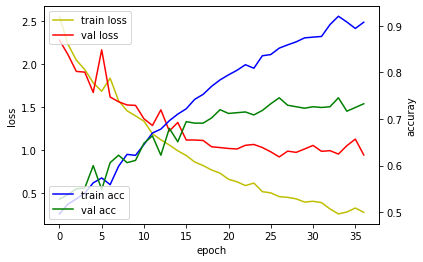

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [17]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('aug_cnn3_bilstm2_v2.csv', index=False)

In [18]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(64, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32, callbacks = [es],  validation_data = (x_val, y_val))

Epoch 1/100
157/157 [==============================] - 175s 629ms/step - loss: 2.8024 - accuracy: 0.4782 - val_loss: 2.4470 - val_accuracy: 0.5280
Epoch 2/100
157/157 [==============================] - 75s 481ms/step - loss: 2.2378 - accuracy: 0.5204 - val_loss: 2.0341 - val_accuracy: 0.5408
Epoch 3/100
157/157 [==============================] - 66s 416ms/step - loss: 2.0945 - accuracy: 0.5187 - val_loss: 1.9577 - val_accuracy: 0.5488
Epoch 4/100
157/157 [==============================] - 63s 399ms/step - loss: 1.9622 - accuracy: 0.5394 - val_loss: 1.9064 - val_accuracy: 0.5664
Epoch 5/100
157/157 [==============================] - 55s 349ms/step - loss: 1.8545 - accuracy: 0.5523 - val_loss: 1.8298 - val_accuracy: 0.5632
Epoch 6/100
157/157 [==============================] - 62s 398ms/step - loss: 1.7068 - accuracy: 0.5852 - val_loss: 1.6109 - val_accuracy: 0.6208
Epoch 7/100
157/157 [==============================] - 54s 345ms/step - loss: 1.6259 - accuracy: 0.5774 - val_loss: 1.5058 

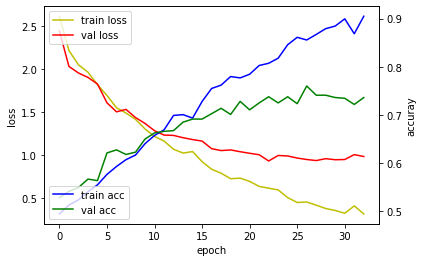

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
prediction=model.predict(test_X)
submission.iloc[:,1:]=prediction
submission.to_csv('.csv', index=False)

In [20]:
x.shape

(5000, 600, 6)

In [21]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(32, return_sequences = True)))
model.add(Bidirectional(GRU(64, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32, callbacks = [es],  validation_data = (x_val, y_val))

Epoch 1/100
157/157 [==============================] - 26s 135ms/step - loss: 2.7808 - accuracy: 0.4687 - val_loss: 2.1642 - val_accuracy: 0.5392
Epoch 2/100
157/157 [==============================] - 19s 121ms/step - loss: 2.2277 - accuracy: 0.5062 - val_loss: 1.8248 - val_accuracy: 0.5680
Epoch 3/100
157/157 [==============================] - 26s 163ms/step - loss: 1.7741 - accuracy: 0.5604 - val_loss: 1.5899 - val_accuracy: 0.6064
Epoch 4/100
157/157 [==============================] - 28s 177ms/step - loss: 1.4998 - accuracy: 0.6143 - val_loss: 1.3328 - val_accuracy: 0.6464
Epoch 5/100
157/157 [==============================] - 26s 165ms/step - loss: 1.2033 - accuracy: 0.6786 - val_loss: 1.2415 - val_accuracy: 0.6848
Epoch 6/100
157/157 [==============================] - 29s 186ms/step - loss: 1.0956 - accuracy: 0.6951 - val_loss: 1.1233 - val_accuracy: 0.6976
Epoch 7/100
157/157 [==============================] - 33s 210ms/step - loss: 0.9573 - accuracy: 0.7332 - val_loss: 1.0970 -

In [22]:
def result_analysis(model_pred,label,threshold,path):
    '''
    model_pred  : 모델의 예측 
    label       : 실제 라벨
    threshold   : weak class로 구분할 기준 accuracy 값 (0~1)
    path        : 그래프 저장경로
    '''
    

    # label dictionary 생성
    train_x_scaled = pd.read_csv('./data/train_features.csv') #train feature load
    train_y = pd.read_csv('./data/train_labels.csv') #label load
    label_dict = dict()
    for label, label_desc in zip(train_y.label, train_y.label_desc):
        label_dict[label] = label_desc
    label_dict[45] ='Squat (kettlebell , goblet)'
    
    class_accuracy = dict()
    if not (path in os.listdir()):
        os.mkdir(path)
        
    for l in range(61):
        desc = label_dict[l]
        idx = label.argmax(axis = 1) == l
        class_pred = model_pred[idx]

        #클래스별 분류 확률 계산
        class_pred = np.unique(class_pred,return_counts = True)
        print((class_pred[1][np.where(class_pred[0]==l)] / class_pred[1].sum()))
        class_accuracy[desc] = (class_pred[1][np.where(class_pred[0]==l)] / class_pred[1].sum())[0]

        if class_accuracy[desc] < threshold: # weak class threshold
            #클래스별 분류 결과 그림
            plt.figure(figsize = (15,10))
            plt.title(desc,fontsize = 20)
            plt.bar([label_dict[l] for l in class_pred[0]],class_pred[1])
            plt.xticks(fontsize = 15,rotation = 90)
            plt.savefig(os.path.join('./' + path,desc), bbox_inches='tight')
            plt.clf()
            plt.close('all')
    plt.figure(figsize = (15,10))
    plt.title('Accuracy by class')
    
    weak_labels = []
    weak_accuracy = []
    for key in class_accuracy.keys():
        if class_accuracy[key] <0.8:
            weak_labels.append(key)
            weak_accuracy.append(class_accuracy[key])
    plt.bar(weak_labels,weak_accuracy)
    plt.xticks(rotation = 90)
    plt.savefig(os.path.join('./' + path,'Weakaccuracy'), bbox_inches='tight')
    plt.clf()
    plt.close('all')

In [24]:
mode_pred = model.predict("test_features")
label = "loaded label"
folder_dir = "folder_directory" #미리 만들지 않아도 자동으로 폴더가 생성됩니다.
result_analysis(model_pred, label,folder_dir)

IndexError: list index out of range

In [16]:
# 0. 사용할 패키지 불러오기
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Conv2D, MaxPooling1D, Bidirectional, GRU
from keras.layers import Flatten

# 2. 모델 구성하기
model = Sequential()
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, padding='same', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(128, return_sequences = False)))
model.add(Dense(61, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 4. 모델 학습시키기
hist = model.fit(x, y, epochs=100, batch_size=32, callbacks = [es],  validation_data = (x_val, y_val))

Epoch 1/100
157/157 [==============================] - 49s 254ms/step - loss: 2.7415 - accuracy: 0.4824 - val_loss: 2.1652 - val_accuracy: 0.5312
Epoch 2/100
157/157 [==============================] - 46s 293ms/step - loss: 2.0726 - accuracy: 0.5282 - val_loss: 1.9563 - val_accuracy: 0.5568
Epoch 3/100
157/157 [==============================] - 51s 323ms/step - loss: 1.9428 - accuracy: 0.5409 - val_loss: 1.9778 - val_accuracy: 0.5344
Epoch 4/100
157/157 [==============================] - 47s 298ms/step - loss: 1.6737 - accuracy: 0.5668 - val_loss: 1.7271 - val_accuracy: 0.5696
Epoch 5/100
157/157 [==============================] - 47s 299ms/step - loss: 1.5862 - accuracy: 0.5840 - val_loss: 1.5978 - val_accuracy: 0.6064
Epoch 6/100
157/157 [==============================] - 49s 314ms/step - loss: 1.5194 - accuracy: 0.5894 - val_loss: 1.4984 - val_accuracy: 0.6304
Epoch 7/100
157/157 [==============================] - 49s 313ms/step - loss: 1.3245 - accuracy: 0.6400 - val_loss: 1.4945 -